# Inverted Alus near skipped exons
## Summary and plots

We took the strictest definition of skipped exons from the HEXEvent database (hg38) and looked for Alus (RepeatMasker) in their flanks (BEDOPS closest-features). We further narrowed down this set down to look at those Alus that are inverted (lying in opposite strands) and flanking (lying on either side of the skipped exon).

In [1]:
import os
import pandas as pd
from itertools import combinations
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
workdir = "/home/dad5925/workdir/"
scriptdir = "/home/dad5925/scripts/"
processed_dir = "/home/dad5925/processing/20210709-bedops/"

In [3]:
#EXON_BED = os.path.join(workdir, "hexevent-all-chr-cassette-0-1-100-100-strict-20210622.bed.sorted")
alu_bed = os.path.join(workdir, "hg38_fasta/family/SINE_Alu")

### BEDOPS closest-features
##### Closest skipped exon to each Alu with signed distance reported
```console
sort-bed $ALU_BED | closest-features --dist --closest - $EXON_BED > ${BEDOPS_OUTDIR}/closest-features--dist--closest-alu-exon.tsv
```

In [4]:
closest_exon_bed = os.path.join(processed_dir, "closest-features--dist--closest-alu-exon.tsv")

In [5]:
bed6_cols = ['chr', 'start', 'end', 'gene', 'score', 'strand']
alu_bed_cols = ['chr', 'start', 'end', 'subfamily', 'sw_score', 'strand',
                'percent_substitution', 'percent_deleted', 'percent_inserted',
                'num_bases_past_end', 'family', 'p1', 'p2', 'p3', 'id', 'dist']
closest_exon_header = ["alu_{}".format(i) for i in alu_bed_cols[:-1]] + \
                        ["exon_{}".format(i) for i in bed6_cols] + ["dist"]

In [6]:
closest_exon_df = pd.read_csv(closest_exon_bed, sep='[\t|]', engine='python', header=None, names=closest_exon_header)

In [7]:
closest_exon_df.head(10)

,alu_chr,alu_start,alu_end,alu_subfamily,alu_sw_score,alu_strand,alu_percent_substitution,alu_percent_deleted,alu_percent_inserted,alu_num_bases_past_end,...,alu_p2,alu_p3,alu_id,exon_chr,exon_start,exon_end,exon_gene,exon_score,exon_strand,dist
0,chr1,26790,27053,AluSp,2070,+,9.5,0.4,0.0,(248929369),...,264,(49),17,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,65038.0
1,chr1,31435,31733,AluJo,2059,+,14.1,0.3,0.3,(248924689),...,298,(14),27,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,60358.0
2,chr1,33465,33509,Alu,233,+,25.0,0.0,0.0,(248922913),...,44,(89),30,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,58582.0
3,chr1,35366,35499,AluJr,1000,+,13.5,0.0,0.0,(248920923),...,133,(179),36,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,56592.0
4,chr1,39623,39924,AluSx,2292,+,12.0,0.0,0.0,(248916498),...,301,(11),41,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,52167.0
5,chr1,40628,40729,AluSz6,666,-,12.9,3.8,0.0,(248915693),...,312,208,42,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,51362.0
6,chr1,51584,51880,AluYj4,2373,+,7.4,0.3,0.0,(248904542),...,297,(14),57,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,40211.0
7,chr1,54818,54938,FLAM_A,680,-,23.3,0.0,0.0,(248901484),...,120,1,62,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,37153.0
8,chr1,61862,62160,AluSc,2412,-,8.1,0.0,0.3,(248894262),...,297,1,66,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,29931.0
9,chr1,76892,77201,AluSz,2305,+,12.9,0.0,0.0,(248879221),...,309,(3),81,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,14890.0


### Finding all pairs of inverted Alus within skipped exon flanking regions

First, filtering on a region +/- WINDOW of the exon.

In [8]:
window = 5000  # (pads either side)

In [9]:
window_df = closest_exon_df[closest_exon_df['dist'].between(-window,window)].dropna(how='any')  # dropna doesn't change anything once window is applied
window_df = window_df.rename_axis('idx').reset_index().astype({'dist': 'int'})
window_df.head(10)

,idx,alu_chr,alu_start,alu_end,alu_subfamily,alu_sw_score,alu_strand,alu_percent_substitution,alu_percent_deleted,alu_percent_inserted,...,alu_p2,alu_p3,alu_id,exon_chr,exon_start,exon_end,exon_gene,exon_score,exon_strand,dist
0,12,chr1,87125,87413,AluJo,1959,-,14.6,0.3,1.4,...,285,1,95,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,4678
1,13,chr1,90920,91213,AluY,2317,+,8.9,0.7,0.3,...,294,(17),102,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,878
2,14,chr1,93728,94031,AluSc,2147,-,14.5,0.0,0.0,...,303,1,108,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,-1489
3,15,chr1,94819,95080,AluY,1886,-,8.8,0.0,3.5,...,309,58,111,chr1,92090.0,92240.0,RP11-34P13.7,108.0,-,-2580
4,22,chr1,108329,108564,AluJb,882,+,18.3,22.9,1.3,...,301,(11),136,chr1,112699.0,112804.0,RP11-34P13.7,108.0,-,4136
5,23,chr1,109835,110009,FAM,906,-,22.4,0.0,2.9,...,172,4,139,chr1,112699.0,112804.0,RP11-34P13.7,108.0,-,2691
6,24,chr1,111080,111386,AluSq2,2294,+,11.4,0.0,0.3,...,305,(8),142,chr1,112699.0,112804.0,RP11-34P13.7,108.0,-,1314
7,25,chr1,121269,121565,AluY,2565,-,5.4,0.0,0.0,...,296,1,156,chr1,120720.0,120932.0,RP11-34P13.7,108.0,-,-338
8,26,chr1,124567,124870,AluJb,1962,+,16.8,1.3,0.0,...,307,(5),163,chr1,120720.0,120932.0,RP11-34P13.7,108.0,-,-3636
9,27,chr1,127781,128051,AluSz,1991,-,13.0,0.0,0.0,...,270,1,168,chr1,129054.0,129223.0,RP11-34P13.7,108.0,-,1004


Next, reporting all combinations of Alu pairs (rows) for each exon (group). 

In [10]:
keep_exon_cols = ['exon_chr','exon_start','exon_end', 'exon_gene', 'exon_score', 'exon_strand']
grouped_df = window_df.groupby(keep_exon_cols, sort=False)[['alu_strand', 'idx']].apply(lambda x: list(combinations(x.values,2))).apply(pd.Series).stack().reset_index(name='strand_pairs')
grouped_df[['upstream', 'downstream']] = pd.DataFrame(grouped_df['strand_pairs'].tolist(), columns=['upstream', 'downstream'])
grouped_df[['upstream_strand', 'upstream_id']] = pd.DataFrame(grouped_df['upstream'].tolist(), columns=['upstream_strand', 'upstream_idx'])
grouped_df[['downstream_strand', 'downstream_id']] = pd.DataFrame(grouped_df['downstream'].tolist(), columns=['downstream_strand', 'downstream_idx'])
grouped_df = grouped_df.astype({'exon_start': 'int', 'exon_end': 'int'})

In [11]:
grouped_df.head(10)

,exon_chr,exon_start,exon_end,exon_gene,exon_score,exon_strand,level_6,strand_pairs,upstream,downstream,upstream_strand,upstream_id,downstream_strand,downstream_id
0,chr1,92090,92240,RP11-34P13.7,108.0,-,0,"([-, 12], [+, 13])","[-, 12]","[+, 13]",-,12,+,13
1,chr1,92090,92240,RP11-34P13.7,108.0,-,1,"([-, 12], [-, 14])","[-, 12]","[-, 14]",-,12,-,14
2,chr1,92090,92240,RP11-34P13.7,108.0,-,2,"([-, 12], [-, 15])","[-, 12]","[-, 15]",-,12,-,15
3,chr1,92090,92240,RP11-34P13.7,108.0,-,3,"([+, 13], [-, 14])","[+, 13]","[-, 14]",+,13,-,14
4,chr1,92090,92240,RP11-34P13.7,108.0,-,4,"([+, 13], [-, 15])","[+, 13]","[-, 15]",+,13,-,15
5,chr1,92090,92240,RP11-34P13.7,108.0,-,5,"([-, 14], [-, 15])","[-, 14]","[-, 15]",-,14,-,15
6,chr1,112699,112804,RP11-34P13.7,108.0,-,0,"([+, 22], [-, 23])","[+, 22]","[-, 23]",+,22,-,23
7,chr1,112699,112804,RP11-34P13.7,108.0,-,1,"([+, 22], [+, 24])","[+, 22]","[+, 24]",+,22,+,24
8,chr1,112699,112804,RP11-34P13.7,108.0,-,2,"([-, 23], [+, 24])","[-, 23]","[+, 24]",-,23,+,24
9,chr1,120720,120932,RP11-34P13.7,108.0,-,0,"([-, 25], [+, 26])","[-, 25]","[+, 26]",-,25,+,26


Then taking Alu pairs that are inverted (+ strand and - strand).

In [12]:
ir_df = grouped_df[(grouped_df.upstream_strand != grouped_df.downstream_strand)]

In [13]:
cols = ['alu_subfamily','alu_id', 'dist']
rename_upstream_cols = dict(zip(cols,["upstream_{}".format(i) for i in cols]))
rename_downstream_cols = dict(zip(cols,["downstream_{}".format(i) for i in cols]))

In [14]:
ir_df = ir_df.merge(window_df[['idx'] + cols]
                    .rename(columns={'idx': 'upstream_id'} | rename_upstream_cols),
                    on='upstream_id', how='left')
ir_df = ir_df.merge(window_df[['idx'] + cols]
                    .rename(columns={'idx': 'downstream_id'} | rename_downstream_cols),
                    on='downstream_id', how='left')

In [15]:
ir_df.head(10)

,exon_chr,exon_start,exon_end,exon_gene,exon_score,exon_strand,level_6,strand_pairs,upstream,downstream,upstream_strand,upstream_id,downstream_strand,downstream_id,upstream_alu_subfamily,upstream_alu_id,upstream_dist,downstream_alu_subfamily,downstream_alu_id,downstream_dist
0,chr1,92090,92240,RP11-34P13.7,108.0,-,0,"([-, 12], [+, 13])","[-, 12]","[+, 13]",-,12,+,13,AluJo,95,4678,AluY,102,878
1,chr1,92090,92240,RP11-34P13.7,108.0,-,3,"([+, 13], [-, 14])","[+, 13]","[-, 14]",+,13,-,14,AluY,102,878,AluSc,108,-1489
2,chr1,92090,92240,RP11-34P13.7,108.0,-,4,"([+, 13], [-, 15])","[+, 13]","[-, 15]",+,13,-,15,AluY,102,878,AluY,111,-2580
3,chr1,112699,112804,RP11-34P13.7,108.0,-,0,"([+, 22], [-, 23])","[+, 22]","[-, 23]",+,22,-,23,AluJb,136,4136,FAM,139,2691
4,chr1,112699,112804,RP11-34P13.7,108.0,-,2,"([-, 23], [+, 24])","[-, 23]","[+, 24]",-,23,+,24,FAM,139,2691,AluSq2,142,1314
5,chr1,120720,120932,RP11-34P13.7,108.0,-,0,"([-, 25], [+, 26])","[-, 25]","[+, 26]",-,25,+,26,AluY,156,-338,AluJb,163,-3636
6,chr1,129054,129223,RP11-34P13.7,108.0,-,3,"([-, 27], [+, 31])","[-, 27]","[+, 31]",-,27,+,31,AluSz,168,1004,AluJo,173,-566
7,chr1,129054,129223,RP11-34P13.7,108.0,-,4,"([-, 27], [+, 32])","[-, 27]","[+, 32]",-,27,+,32,AluSz,168,1004,AluSg,175,-776
8,chr1,129054,129223,RP11-34P13.7,108.0,-,5,"([-, 27], [+, 33])","[-, 27]","[+, 33]",-,27,+,33,AluSz,168,1004,AluSq,176,-1533
9,chr1,129054,129223,RP11-34P13.7,108.0,-,9,"([-, 28], [+, 31])","[-, 28]","[+, 31]",-,28,+,31,AluSq2,170,162,AluJo,173,-566


And finally filtering on pairs that actually flank the exon (lie on either side).

In [16]:
flank_ir_df = ir_df[(ir_df['upstream_dist']>0) & (ir_df['downstream_dist']<0)]

In [17]:
flank_ir_df.head(10)

,exon_chr,exon_start,exon_end,exon_gene,exon_score,exon_strand,level_6,strand_pairs,upstream,downstream,upstream_strand,upstream_id,downstream_strand,downstream_id,upstream_alu_subfamily,upstream_alu_id,upstream_dist,downstream_alu_subfamily,downstream_alu_id,downstream_dist
1,chr1,92090,92240,RP11-34P13.7,108.0,-,3,"([+, 13], [-, 14])","[+, 13]","[-, 14]",+,13,-,14,AluY,102,878,AluSc,108,-1489
2,chr1,92090,92240,RP11-34P13.7,108.0,-,4,"([+, 13], [-, 15])","[+, 13]","[-, 15]",+,13,-,15,AluY,102,878,AluY,111,-2580
6,chr1,129054,129223,RP11-34P13.7,108.0,-,3,"([-, 27], [+, 31])","[-, 27]","[+, 31]",-,27,+,31,AluSz,168,1004,AluJo,173,-566
7,chr1,129054,129223,RP11-34P13.7,108.0,-,4,"([-, 27], [+, 32])","[-, 27]","[+, 32]",-,27,+,32,AluSz,168,1004,AluSg,175,-776
8,chr1,129054,129223,RP11-34P13.7,108.0,-,5,"([-, 27], [+, 33])","[-, 27]","[+, 33]",-,27,+,33,AluSz,168,1004,AluSq,176,-1533
9,chr1,129054,129223,RP11-34P13.7,108.0,-,9,"([-, 28], [+, 31])","[-, 28]","[+, 31]",-,28,+,31,AluSq2,170,162,AluJo,173,-566
10,chr1,129054,129223,RP11-34P13.7,108.0,-,10,"([-, 28], [+, 32])","[-, 28]","[+, 32]",-,28,+,32,AluSq2,170,162,AluSg,175,-776
11,chr1,129054,129223,RP11-34P13.7,108.0,-,11,"([-, 28], [+, 33])","[-, 28]","[+, 33]",-,28,+,33,AluSq2,170,162,AluSq,176,-1533
22,chr1,142946,143011,onlyEST,116.0,-,3,"([+, 35], [-, 39])","[+, 35]","[-, 39]",+,35,-,39,FLAM_A,180,2455,AluJb,187,-154
24,chr1,142946,143011,onlyEST,116.0,-,8,"([+, 36], [-, 39])","[+, 36]","[-, 39]",+,36,-,39,AluJo,181,2163,AluJb,187,-154


# Plots

### All Alus

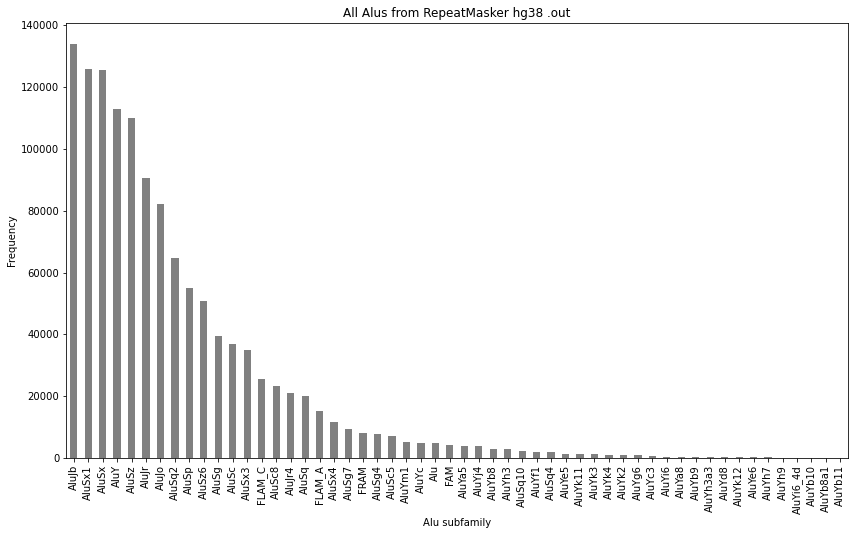

Total number of Alus:  1262524


In [18]:
fig, ax = plt.subplots()
alu_df = pd.read_csv(alu_bed, sep='\t', header=None)
ax = alu_df[3].value_counts().plot(kind='bar', figsize=(14,8), color='grey', title="All Alus from RepeatMasker hg38 .out")
ax.set_xlabel("Alu subfamily")
ax.set_ylabel("Frequency")
plt.show()
print("Total number of Alus: ", len(alu_df))

In [19]:
alu_sort_idx = list(alu_df[3].value_counts().index)
alu_window_idx_set = frozenset(list(window_df['alu_subfamily'].value_counts().index))
window_idx = [x for x in alu_sort_idx if x in alu_window_idx_set]

### Alus within +/- WINDOW of skipped exons

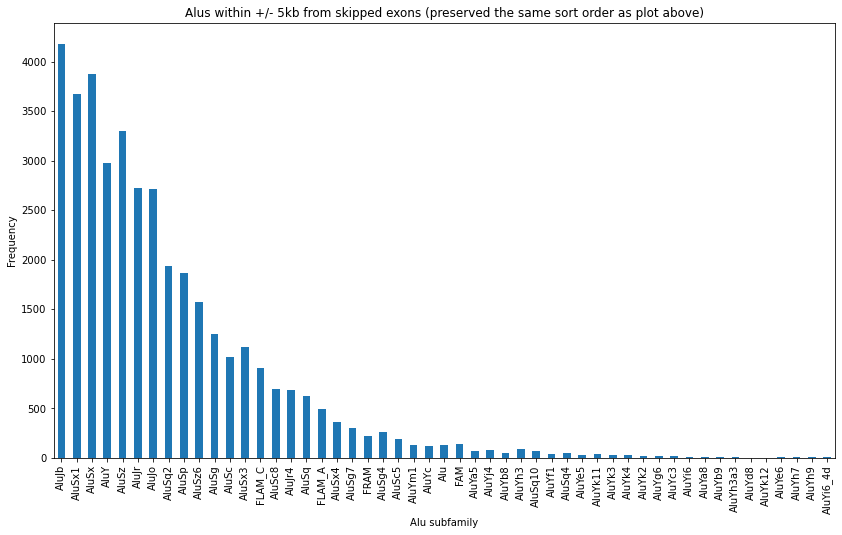

Total number of Alus within +/- 5kb of skipped exons:  38247


In [20]:
ax = window_df['alu_subfamily'].value_counts()[window_idx].plot(kind='bar', figsize=(14,8), title="Alus within +/- 5kb from skipped exons (preserved the same sort order as plot above)")
ax.set_xlabel("Alu subfamily")
ax.set_ylabel("Frequency")
plt.show()
print("Total number of Alus within +/- 5kb of skipped exons: ", len(window_df))

### Inverted Alus (within window)

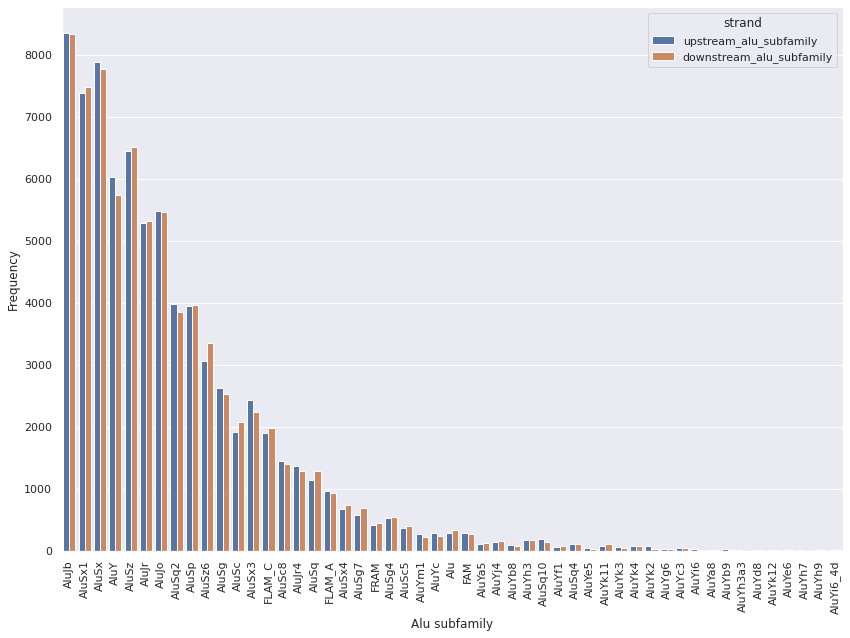

Total number of Alu pairs that are inverted and within +/- 5kb of skipped exons:  76837


In [21]:
import seaborn as sns
import matplotlib.pylab as plt
sns.set(rc={'figure.figsize':(14,10)})

stacked_df = (ir_df[['upstream_alu_subfamily', 'downstream_alu_subfamily']]
              .stack()
              .rename("alu_subfamily")
              .rename_axis([None, 'strand'])
              .reset_index(level=1))

ax = sns.countplot(data=stacked_df,x='alu_subfamily',hue='strand', order=window_idx)
plt.xticks(rotation=90)
ax.set_xlabel("Alu subfamily")
ax.set_ylabel("Frequency")
plt.show()
print("Total number of Alu pairs that are inverted and within +/- 5kb of skipped exons: ", len(ir_df))

### Inverted AND flanking exon (within window)

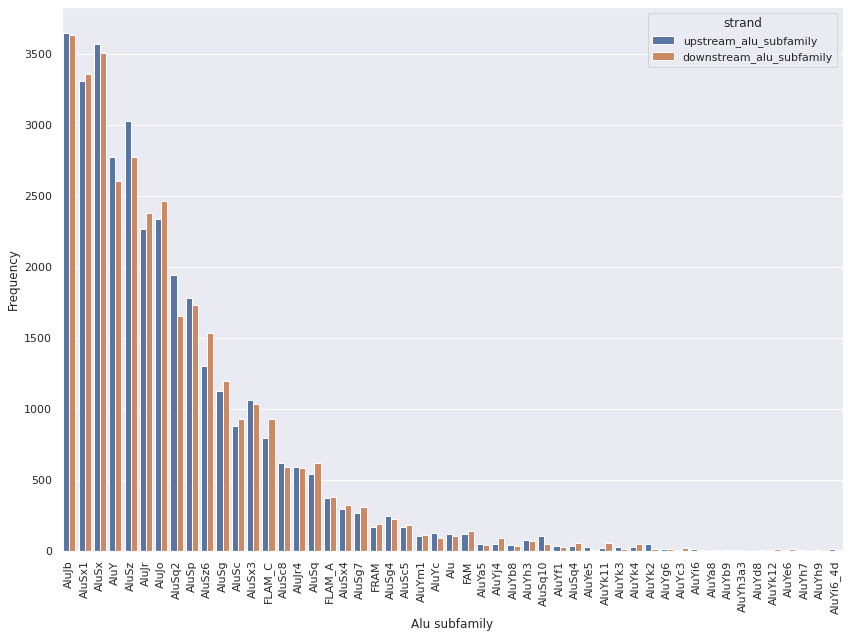

Total number of flanking Alu pairs that are inverted and within +/- 5kb of skipped exons:  34158


In [22]:
stacked_df = (flank_ir_df[['upstream_alu_subfamily', 'downstream_alu_subfamily']]
              .stack()
              .rename("alu_subfamily")
              .rename_axis([None, 'strand'])
              .reset_index(level=1))

ax = sns.countplot(data=stacked_df,x='alu_subfamily',hue='strand', order=window_idx)
plt.xticks(rotation=90)
ax.set_xlabel("Alu subfamily")
ax.set_ylabel("Frequency")
plt.show()
print("Total number of flanking Alu pairs that are inverted and within +/- 5kb of skipped exons: ", len(flank_ir_df))

### Enrichment

Questions/Todo:
- Try to compute 2x2 across all subfamilies
- What fraction of exons have nearby Alus?
- Above plots: what about Alu length? Also plot distance
- Repeat analyses looking only at two nearest Alus?
- Compute enrichment across windows (500b-5kb)
- Facet plots across windows
- Facet the above plots (col)

      | Alu | Non-Alu (or other Alus)
---------------------
Exon 
____
Non-exon


     | IR Alu | Non-IR Alu
---------------------------
Exon
____
Non-exon
